In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rubin_sim.maf as maf
from rubin_sim.data import get_baseline
from rubin_scheduler.scheduler.utils import SkyAreaGenerator
import sqlite3
from astropy.time import Time
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

/home/idies/lsst/conda/miniconda3-py37_4.8.2/envs/rubin/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


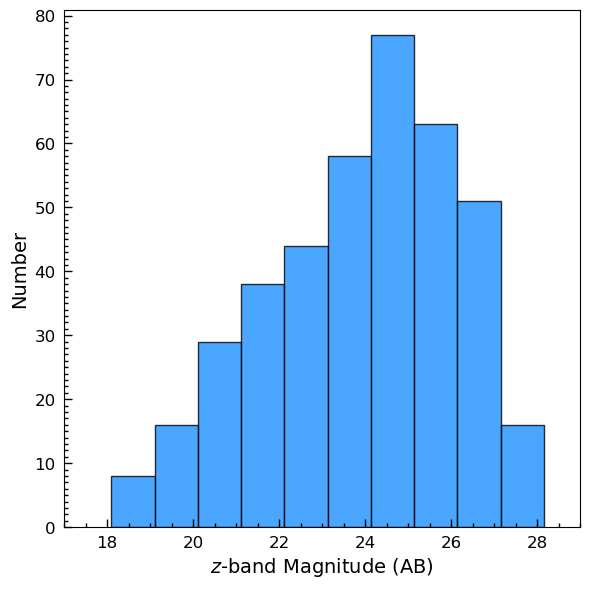

In [3]:
df = pd.read_csv('Luo_F606.csv')

# Filter rows for 'AGN' type
df_agn = df[df['OType'] == 'AGN']

# Extract relevant data
z_mag = np.array(df_agn['GOODSSmag'])
F606 = np.array(df_agn['ACS_F606W_FLUX'])
F606_e = np.array(df_agn['ACS_F606W_FLUXERR'])

# Convert Flux to Magnitude (AB)
r_mag = -2.5 * np.log10(F606 * 1e-6 / 3631)

# Remove NaN values from r_mag
r_mag = r_mag[~np.isnan(r_mag)]

# Create the plot
fig, ax = plt.subplots(figsize=[6, 6])

# Plot histogram of z-band Magnitude
n, bins, _ = ax.hist(z_mag,edgecolor='k', color='dodgerblue', alpha=0.8)

# Set plot labels
ax.set_xlabel(r'$z$-band Magnitude (AB)', fontsize=14)
ax.set_ylabel('Number', fontsize=14)

# Customize ticks and grids
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(1))

ax.tick_params(axis='both', which='major', tickdir='in', labelsize=12, width=1, pad=6, length=6, 
               bottom=True, top=False, left=True, right=False, labelbottom=True, labeltop=False, labelleft=True)
ax.tick_params(axis='both', which='minor', tickdir='in', width=1, length=3, bottom=True, top=False, left=True, right=False)

# Set x-axis limits
ax.set_xlim(17, 29)

# Save and display the plot
plt.tight_layout()
plt.savefig('AGN_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


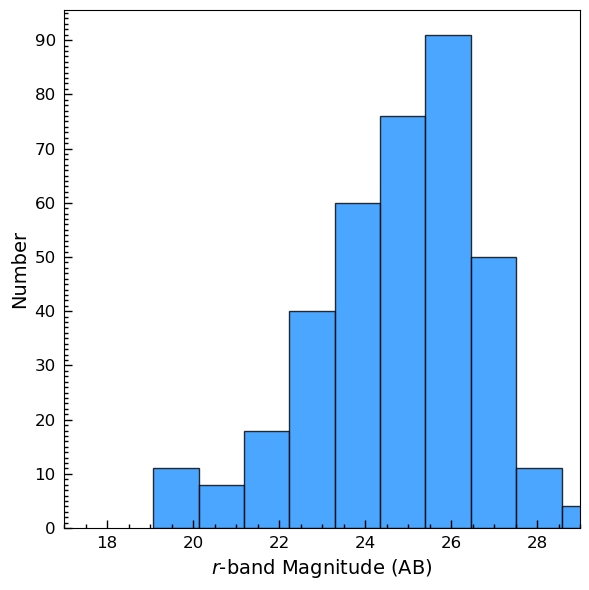

In [4]:
fig, ax = plt.subplots(figsize=[6, 6])

# Plot histogram for r_mag
n, bins, _ = ax.hist(r_mag,edgecolor='k', color='dodgerblue', alpha=0.8)

# Set labels and title
ax.set_xlabel(r'$r$-band Magnitude (AB)', fontsize=14)
ax.set_ylabel('Number', fontsize=14)

# Customize the tick marks and grid
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(1))

ax.tick_params(axis='both', which='major', tickdir='in', labelsize=12, width=1, pad=6, length=6,
               bottom=True, top=False, left=True, right=False, labelbottom=True, labeltop=False, labelleft=True)
ax.tick_params(axis='both', which='minor', tickdir='in', width=1, length=3, bottom=True, top=False, left=True, right=False)

# Set the x-axis limits
ax.set_xlim(17, 29)

# Show the plot
plt.tight_layout()
plt.show()


In [7]:
def get_time_range(baseline):
    """
    Query the baseline database to get the observation time range.

    Parameters:
    baseline (str): Path to the baseline database file.

    Returns:
    tuple: Start and end MJD of observations.
    """
    conn = sqlite3.connect(baseline)
    cursor = conn.cursor()
    
    query = "SELECT MIN(observationStartMJD), MAX(observationStartMJD) FROM observations"
    cursor.execute(query)
    result = cursor.fetchone()
    
    conn.close()
    
    return result

baseline = '/home/idies/workspace/Storage/LiGuodong/persistent/LSST_NQSO/Baseline_4_0/Baseline/baseline_v4.0_10yrs.db'
start_mjd, end_mjd = get_time_range(baseline)
start_date = Time(start_mjd, format='mjd').to_value('iso', subfmt='date')
end_date = Time(end_mjd, format='mjd').to_value('iso', subfmt='date')

# Calculate the difference in years
start_time = Time(start_mjd, format='mjd')
end_time = Time(end_mjd, format='mjd')
difference_in_years = (end_time - start_time).to('year')

print(f"Start MJD: {start_mjd}, End MJD: {end_mjd}")
print(f"Start Date: {start_date}")
print(f"End Date: {end_date}")
print(f"Difference in Years: {difference_in_years:.2f}")

Start MJD: 60796.00143922635, End MJD: 64448.42922491617
Start Date: 2025-05-01
End Date: 2035-05-01
Difference in Years: 10.00 yr


/home/idies/lsst/conda/miniconda3-py37_4.8.2/envs/rubin/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/idies/lsst/conda/miniconda3-py37_4.8.2/envs/rubin/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


In [8]:
def calculate_monthly_depth(baseline, nside, maps, outdir, ourdir_db, start_mjd):
    """
    Function to calculate the 5-sigma depth for each month for a given period (10 years).
    
    Parameters:
    - baseline (str): Path to the baseline database file.
    - nside (int): HEALPix resolution parameter.
    - maps (array): Array of HEALPix IDs for the selected regions.
    - outdir (str): Directory to store the output results.
    - ourdir_db (str): Directory to store the results database.
    - start_mjd (float): Start MJD (Modified Julian Date) for the observations.
    
    Returns:
    - annual_bundles (dict): Dictionary containing the MetricBundles for each month.
    """
    
    # Extract the run name from the baseline database file (used for naming)
    baseline_file = baseline
    run_name = os.path.split(baseline_file)[-1].replace('.db', '')
    
    # Initialize a dictionary to hold MetricBundles for each month (1 to 120 for 10 years)
    annual_bundles = {month: {} for month in range(1, 121)}  # 120 months in 10 years
    
    # Create a DustMap for the given nside resolution
    dustmap = maf.DustMap(nside=nside)
    
    # Define the slicer for dividing the sky into equal-area pixels using the selected maps
    slicer = maf.HealpixSubsetSlicer(nside=nside, use_cache=False, hpid=maps)

    # Loop over each month (1 to 120)
    for month in range(1, 121):
        print(f"Processing month {month}...")  # Print progress
        
        # Loop through each filter ('u', 'g', 'r', 'i', 'z', 'y')
        for f in ('u', 'g', 'r', 'i', 'z', 'y'):
            # Define the metric to calculate the 5-sigma depth (Coaddm5Metric)
            metric = maf.Coaddm5Metric()
            
            # Define the start and end MJD for the current month
            month_start_mjd = start_mjd
            month_end_mjd = start_mjd + month * 30.44  # Assume each month has 30.44 days
            
            # Define the SQL query to filter the observations for the current filter and month
            sql = f'filter = "{f}" and observationStartMJD >= {month_start_mjd} and observationStartMJD < {month_end_mjd}'
            
            # Create a MetricBundle for the current filter and month
            bundle = maf.MetricBundle(
                metric, 
                slicer, 
                sql, 
                run_name=f'{run_name}_month{month}',  # Use a unique run name for each month
                maps_list=[dustmap], 
                info_label=f'{f} band month {month}'
            )
            # Store the MetricBundle in the annual_bundles dictionary
            annual_bundles[month][f] = bundle
        
        # Create a results database directory for the current month
        results_db = maf.db.ResultsDb(out_dir=os.path.join(ourdir_db, f'{run_name}_month{month}'))
        
        # Create a MetricBundleGroup for the current month using all the MetricBundles
        bundle_group = maf.MetricBundleGroup(
            annual_bundles[month],  # Flatten the dictionary for MetricBundleGroup
            baseline_file, 
            out_dir=outdir, 
            results_db=results_db
        )
        
        # Run the MetricBundleGroup to calculate the 5-sigma depth for the current month
        bundle_group.run_all()
        
    # Return the annual_bundles dictionary containing the MetricBundles for each month
    return annual_bundles

In [9]:
def calculate_DDF_monthly_depth(baseline, nside, maps, outdir, ourdir_db, start_mjd):
    baseline_file = baseline
    run_name = os.path.split(baseline_file)[-1].replace('.db', '')
    annual_bundles = {month: {} for month in range(1, 121)}  # 10年 = 120个月
    dustmap = maf.DustMap(nside=nside)
    slicer = maf.HealpixSubsetSlicer(nside=nside, use_cache=False, hpid=maps)

    for month in range(1,121):
        print(f"Processing month {month}...")
        for f in ('u', 'g', 'r', 'i', 'z', 'y'):
            metric = maf.Coaddm5Metric()
            month_start_mjd = start_mjd
            month_end_mjd = start_mjd + month * 30.44
            #sql = f'target_name not like "DD%" and filter = "{f}" and observationStartMJD >= {month_start_mjd} and observationStartMJD < {month_end_mjd}'
            sql = f'target_name like "DD%" and filter = "{f}" and observationStartMJD >= {month_start_mjd} and observationStartMJD < {month_end_mjd}'
            bundle = maf.MetricBundle(metric, slicer, sql, run_name=f'{run_name}_month{month}', maps_list=[dustmap], info_label=f'{f} band month {month}')
            annual_bundles[month][f] = bundle
        
        results_db = maf.db.ResultsDb(out_dir=os.path.join(ourdir_db, f'{run_name}_month{month}'))
        # Flatten the annual_bundles[month] dictionary for MetricBundleGroup
        bundle_group = maf.MetricBundleGroup(annual_bundles[month], baseline_file, out_dir=outdir, results_db=results_db)    
        bundle_group.run_all()
        
    return annual_bundles

In [10]:
baseline = '/home/idies/workspace/Storage/LiGuodong/persistent/LSST_NQSO/Baseline_4_0/Baseline/baseline_v4.0_10yrs.db'
nside = 64
outdir = '/home/idies/workspace/Temporary/LiGuodong/scratch/EM5_MAFOutput/Baseline/AGN'
ourdir_db = '/home/idies/workspace/Temporary/LiGuodong/scratch/EM5_MAFOutput/Baseline/AGN/MetricData/'

# Get the time range from the database
start_mjd, end_mjd = get_time_range(baseline)
print(f"Start MJD: {start_mjd}, End MJD: {end_mjd}")

# Generate survey areas
survey_areas = SkyAreaGenerator(nside=nside)
map_footprints, map_labels = survey_areas.return_maps()

# Select HEALPix IDs for specific regions
maps = np.where(
    (map_labels == 'LMC_SMC') |
    (map_labels == 'bulge') |
    (map_labels == 'dusty_plane') |
    (map_labels == '') |
    (map_labels == 'lowdust') |
    (map_labels == 'nes') |
    (map_labels == 'scp') |
    (map_labels == 'virgo')
)[0]

monthly_depth = calculate_monthly_depth(baseline, nside, maps, outdir, ourdir_db, start_mjd)

Start MJD: 60796.00143922635, End MJD: 64448.42922491617
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Processing month 1...
Processing month 2...
Processing month 3...
Processing month 4...
Processing month 5...
Processing month 6...
Processing month 7...
Processing month 8...
Processing month 9...
Processing month 10...
Processing month 11...
Processing month 12...
Processing month 13...
Processing month 14...
Processing month 15...
Processing month 16...
Processing month 17...
Processing month 18...
Processing month 19...
Processing month 20...
Processing month 21...
Processing month 22...
Processing month 23...
Processing month 24...
Processing month 25...
Processing month 26...
Processing month 27...
Processing month 28...
Processing month 29...
Processing month 30...
Processing month 31...
Processing month 32...
Processing month 33...
Processing month 34...
Processing month 35...
Processing month 36...
Processing month 37...
Processing month 38...
Pro

In [ ]:
baseline = '/home/idies/workspace/Storage/LiGuodong/persistent/LSST_NQSO/Baseline_4_0/Baseline/baseline_v4.0_10yrs.db'
nside = 64
outdir = '/home/idies/workspace/Temporary/LiGuodong/scratch/EM5_MAFOutput/Baseline/AGN'
ourdir_db = '/home/idies/workspace/Temporary/LiGuodong/scratch/EM5_MAFOutput/Baseline/AGN/MetricData/'

# Get the time range from the database
start_mjd, end_mjd = get_time_range(baseline)
print(f"Start MJD: {start_mjd}, End MJD: {end_mjd}")

# Generate survey areas
survey_areas = SkyAreaGenerator(nside=nside)
map_footprints, map_labels = survey_areas.return_maps()

# Select HEALPix IDs for specific regions
maps = np.where(
    (map_labels == 'LMC_SMC') |
    (map_labels == 'bulge') |
    (map_labels == 'dusty_plane') |
    (map_labels == '') |
    (map_labels == 'lowdust') |
    (map_labels == 'nes') |
    (map_labels == 'scp') |
    (map_labels == 'virgo')
)[0]

monthly_depth = calculate_DDF_monthly_depth(baseline, nside, maps, outdir, ourdir_db, start_mjd)

Start MJD: 60796.00143922635, End MJD: 64448.42922491617
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Processing month 1...
Processing month 2...
Processing month 3...
Processing month 4...
Processing month 5...
Processing month 6...
Processing month 7...
Processing month 8...
Processing month 9...
Processing month 10...
Processing month 11...
Processing month 12...
Processing month 13...
Processing month 14...
Processing month 15...
Processing month 16...
Processing month 17...
Processing month 18...
Processing month 19...
Processing month 20...
Processing month 21...
Processing month 22...
Processing month 23...
Processing month 24...
Processing month 25...
Processing month 26...
Processing month 27...
Processing month 28...
Processing month 29...
Processing month 30...
Processing month 31...
Processing month 32...
Processing month 33...
Processing month 34...
Processing month 35...
Processing month 36...
Processing month 37...
Processing month 38...
Pro

In [10]:
from rubin_sim.maf import MetricBundle, MetricBundleGroup

def extract_data(npz_file, magnitude_distribution, nside):
    bundle = MetricBundle.load(npz_file)
    depths = bundle.metric_values.compressed()
    survey_area = 160/3600
    nside = 64
    npix = 12 * nside**2
    area_per_pixel = 41253 / npix
    
    total_agn_count = 0  # Initialize the total AGN count
    effective_pixels = 0  # Count of pixels with detectable AGN

    # Loop through depth values to calculate AGN counts
    for depth in depths:
        # Find AGN within the magnitude limit defined by the depth
        detectable_agn_mask = magnitude_distribution <= depth
        detectable_agn_count = len(magnitude_distribution[detectable_agn_mask])

        if detectable_agn_count > 0:
            effective_pixels += 1  # Increment the count of effective pixels
            # Scale the AGN count for the pixel to the total survey area
            total_agn_count += area_per_pixel * detectable_agn_count / survey_area

    # Return the total AGN count and the total surveyed area
    return total_agn_count, effective_pixels * area_per_pixel
    
def create_agn_csv_files(result_dir, output_dir, filters, months, z_mag, r_mag, nside):
    
    df = pd.DataFrame(index=[f"{f}" for f in filters], columns=months)
    
    for f in filters:
        for month in months:
            npz_file = os.path.join(result_dir, f"baseline_v4_0_10yrs_month{month}_CoaddM5_{f}_band_month_{month}_HEAL.npz")
            if f=='z':
                magnitude_distribution = z_mag
            elif f=='r':
                magnitude_distribution = r_mag
            else:
                pass
            number, area = extract_data(npz_file, magnitude_distribution, nside)
            df.at[f"{f}", month] = number
    df.to_csv('AGN_month.csv')
    
result_dir = '/home/idies/workspace/Temporary/LiGuodong/scratch/EM5_MAFOutput/Baseline/AGN'          
output_dir = './' 
filters = ['r', 'z']
months = range(1, 121)
create_agn_csv_files(result_dir, output_dir, filters, months, z_mag, r_mag, 64)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSID

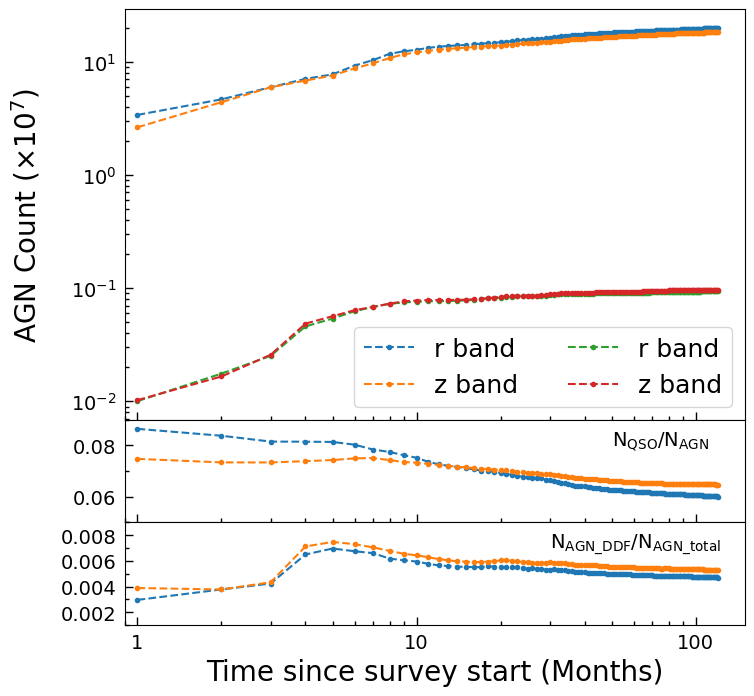

In [6]:
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

def plot_qso_counts_over_months_percentage(ax, df, df2):
    months = range(1, 121)
    filters = ['r', 'z']
    qso_counts = {f: [] for f in filters}
    AGN_counts = {f: [] for f in filters}
    dates = []

    for month in months:
        for f in filters:
            qso_counts[f].append(df2[str(month)][f])
            AGN_counts[f].append(df[str(month)][f])
    
    for f in filters:
        ax.plot(months, np.array(qso_counts[f])/np.array(AGN_counts[f]), marker='o', linestyle='--', markersize=3, label=f+' band')

    ymajorLocator = MultipleLocator(0.02)
    yminorLocator = MultipleLocator(0.01)
    ax.yaxis.set_major_locator(ymajorLocator)
    ax.yaxis.set_minor_locator(yminorLocator)
    ax.tick_params(axis='both',which='major',tickdir='in',labelsize=14,width=1,pad=6,length=6,bottom=True, top=False, left=True, right=False)
    ax.tick_params(axis='both',which='minor',tickdir='in',width=1,length=3,bottom=True, top=False, left=True, right=False)
    ax.set_xlabel('Time since survey start (Months)',fontsize=20)
    #ax.set_ylabel(r'$\rm N_{QSO}/N_{AGN}$',fontsize=14, labelpad=12)
    ax.text(50, 0.08, r'$\rm N_{QSO}/N_{AGN}$',fontsize=14)
    ax.set_xscale('log')
    ax.set_xlim(0.9,150)
    ax.set_ylim(0.05,0.09)
    xmajorFormatter = FormatStrFormatter('%.0f')
    ax.xaxis.set_major_formatter(xmajorFormatter)
    ymajorFormatter = FormatStrFormatter('%.2f')
    ax.yaxis.set_major_formatter(ymajorFormatter)
    
def plot_qso_counts_over_months(ax, df):
    months = range(1, 121)
    filters = ['r', 'z']
    qso_counts = {f: [] for f in filters}
    dates = []
    
    for month in months:
        for f in filters:
            qso_counts[f].append(df[str(month)][f])
            
    dict_t = {}
    for f in filters:
        ax.plot(months, np.array(qso_counts[f])/1e7, marker='o', linestyle='--',markersize=3, label=f'{f} band')

    ymajorLocator = MultipleLocator(2)
    yminorLocator = MultipleLocator(1)
    xmajorLocator = MultipleLocator(10)
    xminorLocator = MultipleLocator(2)
    ax.yaxis.set_major_locator(ymajorLocator)
    ax.yaxis.set_minor_locator(yminorLocator)
    ax.xaxis.set_major_locator(xmajorLocator)
    ax.xaxis.set_minor_locator(xminorLocator)
    ax.tick_params(axis='both',which='major',tickdir='in',labelsize=14,width=1,pad=6,length=6,bottom=True, top=False, left=True, right=False)
    ax.tick_params(axis='both',which='minor',tickdir='in',width=1,length=3,bottom=True, top=False, left=True, right=False)
    ax.set_xlabel('Month',fontsize=24)
    #ax.set_ylim(0.001,20)
    ax.set_ylabel(r'AGN Count ($\times 10^{7}$)',fontsize=20, labelpad=20)
    ax.set_xlim(0.9,150)
    ax.legend(loc='lower right', ncol=2, fontsize=18)
    ax.set_xscale('log')
    ax.set_yscale('log')

def plot_qso_counts_over_months_percentage2(ax, df, df2):
    months = range(1, 121)
    filters = ['r', 'z']
    qso_counts = {f: [] for f in filters}
    AGN_counts = {f: [] for f in filters}
    dates = []

    for month in months:
        for f in filters:
            qso_counts[f].append(df2[str(month)][f])
            AGN_counts[f].append(df[str(month)][f])
    
    for f in filters:
        ax.plot(months, np.array(qso_counts[f])/np.array(AGN_counts[f]), marker='o', linestyle='--', markersize=3, label=f+' band')

    ymajorLocator = MultipleLocator(0.002)
    yminorLocator = MultipleLocator(0.001)
    ax.yaxis.set_major_locator(ymajorLocator)
    ax.yaxis.set_minor_locator(yminorLocator)
    ax.tick_params(axis='both',which='major',tickdir='in',labelsize=14,width=1,pad=6,length=6,bottom=True, top=False, left=True, right=False)
    ax.tick_params(axis='both',which='minor',tickdir='in',width=1,length=3,bottom=True, top=False, left=True, right=False)
    ax.set_xlabel('Time since survey start (Months)',fontsize=20)
    #ax.set_ylabel(r'$\rm N_{QSO}/N_{AGN}$',fontsize=14, labelpad=12)
    ax.text(30, 0.007, r'$\rm N_{AGN\_DDF}/N_{AGN\_total}$',fontsize=14)
    ax.set_xscale('log')
    ax.set_xlim(0.9,150)
    ax.set_ylim(0.001,0.009)
    xmajorFormatter = FormatStrFormatter('%.0f')
    ax.xaxis.set_major_formatter(xmajorFormatter)
    ymajorFormatter = FormatStrFormatter('%.3f')
    ax.yaxis.set_major_formatter(ymajorFormatter)
    
def combine(df, df2, df3):
    
    fig, axs = plt.subplots(3, 1, figsize=(8, 8), sharex='col', 
    gridspec_kw={'height_ratios': [4, 1, 1], 'wspace': 0, 'hspace': 0} )
    axs = axs.flatten()
    plot_qso_counts_over_months(axs[0], df)
    plot_qso_counts_over_months(axs[0], df3)
    plot_qso_counts_over_months_percentage(axs[1], df, df2)
    plot_qso_counts_over_months_percentage2(axs[2], df, df3)
    plt.show()

df = pd.read_csv('AGN_month.csv',index_col=0)
df2 = pd.read_csv('QSO_counts.csv',index_col=0)
df3 = pd.read_csv('DDF_AGN_month.csv',index_col=0)
combine(df, df2, df3)

In [16]:
from rubin_sim.maf import MetricBundle, MetricBundleGroup

def extract_depth(npz_file):
    bundle = MetricBundle.load(npz_file)
    depths = bundle.metric_values.compressed()
    return np.median(depths)
    
def create_depth_DDF_csv_files(result_dir, output_dir, filters, months):
    
    df = pd.DataFrame(index=[f"{f}" for f in filters], columns=months)
    
    for f in filters:
        for month in months:
            npz_file = os.path.join(result_dir, f"baseline_v4_0_10yrs_month{month}_CoaddM5_{f}_band_month_{month}_HEAL.npz")
            depth = extract_depth(npz_file)
            df.at[f"{f}", month] = depth
    df.to_csv('DDF_depth_month.csv')
    
result_dir = '/home/idies/workspace/Temporary/LiGuodong/scratch/EM5_MAFOutput/Baseline/AGN'          
output_dir = './' 
filters = ['r', 'z']
months = range(1, 121)
create_depth_DDF_csv_files(result_dir, output_dir, filters, months)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSID

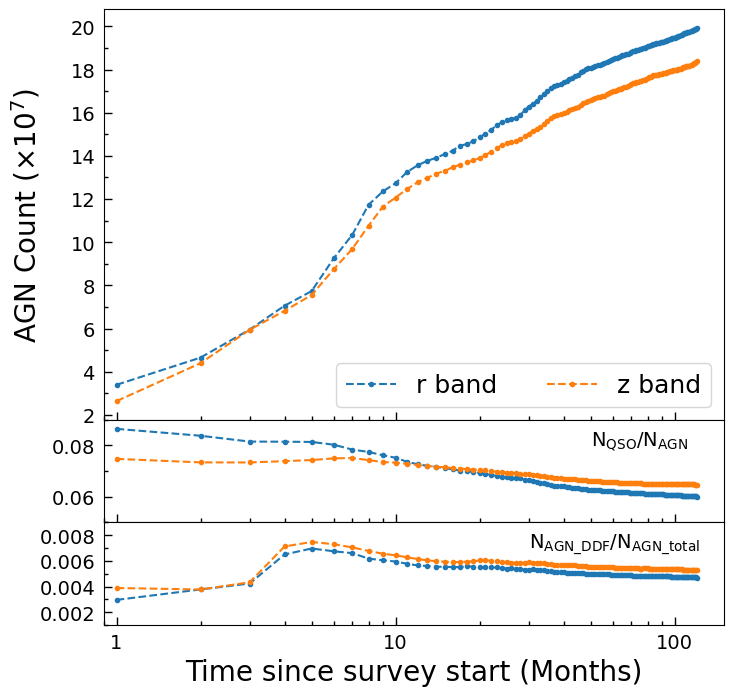

In [22]:
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

def plot_qso_counts_over_months_percentage(ax, df, df2):
    months = range(1, 121)
    filters = ['r', 'z']
    qso_counts = {f: [] for f in filters}
    AGN_counts = {f: [] for f in filters}
    dates = []

    for month in months:
        for f in filters:
            qso_counts[f].append(df2[str(month)][f])
            AGN_counts[f].append(df[str(month)][f])
    
    for f in filters:
        ax.plot(months, np.array(qso_counts[f])/np.array(AGN_counts[f]), marker='o', linestyle='--', markersize=3, label=f+' band')

    ymajorLocator = MultipleLocator(0.02)
    yminorLocator = MultipleLocator(0.01)
    ax.yaxis.set_major_locator(ymajorLocator)
    ax.yaxis.set_minor_locator(yminorLocator)
    ax.tick_params(axis='both',which='major',tickdir='in',labelsize=14,width=1,pad=6,length=6,bottom=True, top=False, left=True, right=False)
    ax.tick_params(axis='both',which='minor',tickdir='in',width=1,length=3,bottom=True, top=False, left=True, right=False)
    ax.set_xlabel('Time since survey start (Months)',fontsize=20)
    #ax.set_ylabel(r'$\rm N_{QSO}/N_{AGN}$',fontsize=14, labelpad=12)
    ax.text(50, 0.08, r'$\rm N_{QSO}/N_{AGN}$',fontsize=14)
    ax.set_xscale('log')
    ax.set_xlim(0.9,150)
    ax.set_ylim(0.05,0.09)
    xmajorFormatter = FormatStrFormatter('%.0f')
    ax.xaxis.set_major_formatter(xmajorFormatter)
    ymajorFormatter = FormatStrFormatter('%.2f')
    ax.yaxis.set_major_formatter(ymajorFormatter)
    
def plot_qso_counts_over_months(ax, df):
    months = range(1, 121)
    filters = ['r', 'z']
    qso_counts = {f: [] for f in filters}
    dates = []
    
    for month in months:
        for f in filters:
            qso_counts[f].append(df[str(month)][f])
            
    dict_t = {}
    for f in filters:
        ax.plot(months, np.array(qso_counts[f])/1e7, marker='o', linestyle='--',markersize=3, label=f'{f} band')

    ymajorLocator = MultipleLocator(2)
    yminorLocator = MultipleLocator(1)
    xmajorLocator = MultipleLocator(10)
    xminorLocator = MultipleLocator(2)
    ax.yaxis.set_major_locator(ymajorLocator)
    ax.yaxis.set_minor_locator(yminorLocator)
    ax.xaxis.set_major_locator(xmajorLocator)
    ax.xaxis.set_minor_locator(xminorLocator)
    ax.tick_params(axis='both',which='major',tickdir='in',labelsize=14,width=1,pad=6,length=6,bottom=True, top=False, left=True, right=False)
    ax.tick_params(axis='both',which='minor',tickdir='in',width=1,length=3,bottom=True, top=False, left=True, right=False)
    ax.set_xlabel('Month',fontsize=24)
    #ax.set_ylim(0.001,20)
    ax.set_ylabel(r'AGN Count ($\times 10^{7}$)',fontsize=20, labelpad=20)
    ax.set_xlim(0.9,150)
    ax.legend(loc='lower right', ncol=2, fontsize=18)
    ax.set_xscale('log')
    #ax.set_yscale('log')

def plot_qso_counts_over_months_percentage2(ax, df, df2):
    months = range(1, 121)
    filters = ['r', 'z']
    qso_counts = {f: [] for f in filters}
    AGN_counts = {f: [] for f in filters}
    dates = []

    for month in months:
        for f in filters:
            qso_counts[f].append(df2[str(month)][f])
            AGN_counts[f].append(df[str(month)][f])
    
    for f in filters:
        ax.plot(months, np.array(qso_counts[f])/np.array(AGN_counts[f]), marker='o', linestyle='--', markersize=3, label=f+' band')

    ymajorLocator = MultipleLocator(0.002)
    yminorLocator = MultipleLocator(0.001)
    ax.yaxis.set_major_locator(ymajorLocator)
    ax.yaxis.set_minor_locator(yminorLocator)
    ax.tick_params(axis='both',which='major',tickdir='in',labelsize=14,width=1,pad=6,length=6,bottom=True, top=False, left=True, right=False)
    ax.tick_params(axis='both',which='minor',tickdir='in',width=1,length=3,bottom=True, top=False, left=True, right=False)
    ax.set_xlabel('Time since survey start (Months)',fontsize=20)
    #ax.set_ylabel(r'$\rm N_{QSO}/N_{AGN}$',fontsize=14, labelpad=12)
    ax.text(30, 0.007, r'$\rm N_{AGN\_DDF}/N_{AGN\_total}$',fontsize=14)
    ax.set_xscale('log')
    ax.set_xlim(0.9,150)
    ax.set_ylim(0.001,0.009)
    xmajorFormatter = FormatStrFormatter('%.0f')
    ax.xaxis.set_major_formatter(xmajorFormatter)
    ymajorFormatter = FormatStrFormatter('%.3f')
    ax.yaxis.set_major_formatter(ymajorFormatter)
    
def combine(df, df2, df3):
    
    fig, axs = plt.subplots(3, 1, figsize=(8, 8), sharex='col', 
    gridspec_kw={'height_ratios': [4, 1, 1], 'wspace': 0, 'hspace': 0} )
    axs = axs.flatten()
    plot_qso_counts_over_months(axs[0], df)
    #plot_qso_counts_over_months(axs[0], df3)
    plot_qso_counts_over_months_percentage(axs[1], df, df2)
    plot_qso_counts_over_months_percentage2(axs[2], df, df3)
    #plt.xticks(rotation=45)
    #plt.savefig('Figure3_1.png', dpi=300, bbox_inches='tight')
    plt.show()

df = pd.read_csv('AGN_month.csv',index_col=0)
df2 = pd.read_csv('QSO_counts.csv',index_col=0)
df3 = pd.read_csv('DDF_AGN_month.csv',index_col=0)
combine(df, df2, df3)

Text(0, 0.5, 'DDF region depths (AB mag)')

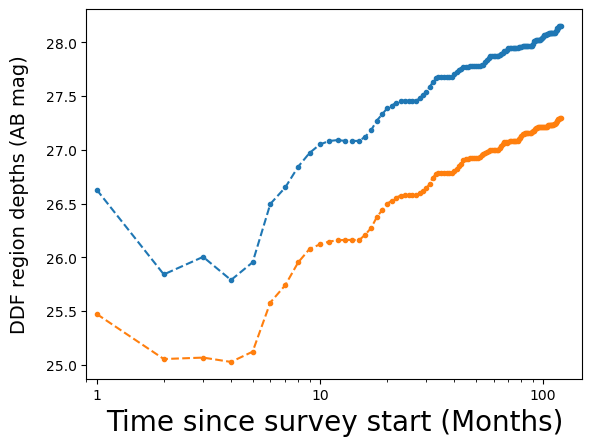

In [21]:
df = pd.read_csv('DDF_depth_month.csv',index_col=0)
months = range(1, 121)
depths = {f: [] for f in filters}
dates = []
for month in months:
    for f in filters:
        depths[f].append(df[str(month)][f])
            


fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(months, np.array(depths['r']), marker='o', linestyle='--',markersize=3, label='r band')
ax.plot(months, np.array(depths['z']), marker='o', linestyle='--',markersize=3, label='r band')
ax.set_xscale('log')
ax.set_xlim(0.9,150)
xmajorFormatter = FormatStrFormatter('%.0f')
ax.xaxis.set_major_formatter(xmajorFormatter)
ax.set_xlabel('Time since survey start (Months)',fontsize=20)
ax.set_ylabel('DDF region depths (AB mag)',fontsize=14, labelpad=12)